In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler as SS
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression as LR, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.ensemble import RandomForestClassifier as RFC, RandomForestRegressor as RFR
from sklearn.model_selection import KFold, GridSearchCV

<font color='green'>Useful functions</font>

In [4]:
# Function to do several runs of KFold and determine if the model works well for training and testing data
def do_Kfold(model,X,y,k,scaler = None, random_state = 146):
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=k, random_state = random_state, shuffle=True)

    train_scores = []
    test_scores = []

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain, :]
        Xtest = X[idxTest, :]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        if scaler != None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        train_scores.append(model.score(Xtrain,ytrain))
        test_scores.append(model.score(Xtest,ytest))
        
    return train_scores, test_scores

In [5]:
# Test the accuracy of a classifier
def compare_classes(actual, predicted, names=None):
    '''Function returns a confusion matrix, and overall accuracy given:
            Input:  actual - a list of actual classifications
                    predicted - a list of predicted classifications
                    names (optional) - a list of class names
    '''
    accuracy = sum(actual==predicted)/actual.shape[0]
    
    classes = pd.DataFrame(columns = ['Actual', 'Predicted'])
    classes['Actual'] = actual
    classes['Predicted'] = predicted

    conf_mat = pd.crosstab(classes['Actual'], classes['Predicted'])
    
    if type(names) != type(None):
        conf_mat.index = names
        conf_mat.index.name = 'Actual'
        conf_mat.columns = names
        conf_mat.columns.name = 'Predicted'
    
    print('Accuracy = ' + format(accuracy, '.2f'))
    return conf_mat, accuracy

<font color='green'>Start of data analysis</font>

In [8]:
# Read in the data and split it up into a set without missing values and a set without the binary variables
data = pd.read_csv("./data/Data.csv")
data_notNA = data.dropna(inplace=False)
data_num = data.drop(columns=["Subject.Code", "Group", "Speed", "Shoe", "Footstrike"])

# Also create a subset of the quantitative data without missing values
data_num_notNA = data_num.dropna(inplace=False)

data.head()

,Subject.Code,Group,Speed,Shoe,Footstrike,Age,Mass,Height,Running.Economy,10K.PB,Contact.Time,BP.ratio,LU.ratio,HV.TD,BP.to.LU,SB,SM.Fit
0,1,1,0,1,1,21.3,63.3,178.6,182.6,29.2,0.2140,0.7258,0.7189,0.0005,1.0096,90.5128,69.901472
1,1,1,0,1,1,21.3,63.3,178.6,182.6,29.2,0.2170,0.8707,0.7500,0.0080,1.1609,92.5127,69.901472
2,1,1,0,1,1,21.3,63.3,178.6,182.6,29.2,0.2280,0.7743,0.7338,0.0030,1.0552,102.6705,69.901472
3,1,1,0,1,1,21.3,63.3,178.6,182.6,29.2,0.2230,0.8279,0.9224,-0.0060,0.8975,87.7199,69.901472
4,1,1,0,1,1,21.3,63.3,178.6,182.6,29.2,0.2245,0.7960,0.6754,0.0090,1.1786,79.3121,69.901472


<font color='green'>PCA and TSNE</font>

In [9]:
# Do PCA to look at general trends in the data
ss = SS()
data_num_scaled = ss.fit_transform(data_num_notNA)
pca = PCA()
data_num_pca = pca.fit_transform(data_num_scaled)
print(pca.components_, '\n', pca.explained_variance_ratio_)

[[ 1.84654285e-01  3.51878880e-01  2.33784817e-01  2.58351574e-01
   3.13879408e-01  3.63048912e-01  2.80626772e-01 -2.46214163e-01
   3.91273553e-01  3.77565751e-01  1.07965041e-01  2.08993394e-01]
 [ 7.71661046e-02  2.97036949e-01  2.49131242e-01  2.94962872e-01
   3.14930681e-01  1.31220589e-01 -1.29418447e-01  3.76939236e-01
  -3.07057133e-01 -3.63743811e-01 -4.71398169e-01  1.80838590e-01]
 [ 3.19718257e-01 -2.53164458e-01 -4.62277179e-01  9.81528361e-02
   3.11375305e-01  1.06978063e-01  4.86663924e-01  4.26461728e-01
  -5.55545600e-05 -3.02118411e-03  4.83757702e-02 -2.84419077e-01]
 [ 7.19313476e-01  1.30411970e-01  3.47046845e-01 -4.05936753e-01
  -1.52441169e-01 -1.99089115e-02 -4.38928013e-02 -5.54793101e-02
  -9.29751090e-03 -1.83466190e-02 -1.30689681e-01 -3.66350433e-01]
 [ 1.40505589e-02 -6.45405503e-02 -8.91416924e-02  4.87237214e-01
   1.65412974e-01  1.74396179e-01 -4.37347822e-01 -3.39763053e-01
  -5.78997638e-02 -4.55026757e-02  6.43566375e-02 -6.13382893e-01]
 [ 2.

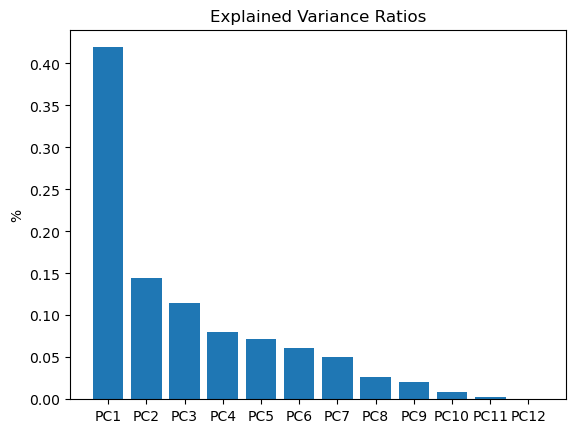

In [10]:
# Plot the percentages of variance explained by the PCs
fig, ax = plt.subplots()
ax.bar(["PC" + str(i) for i in range(1, 13)], pca.explained_variance_ratio_)
ax.set_title("Explained Variance Ratios")
ax.set_ylabel("%")
plt.show()

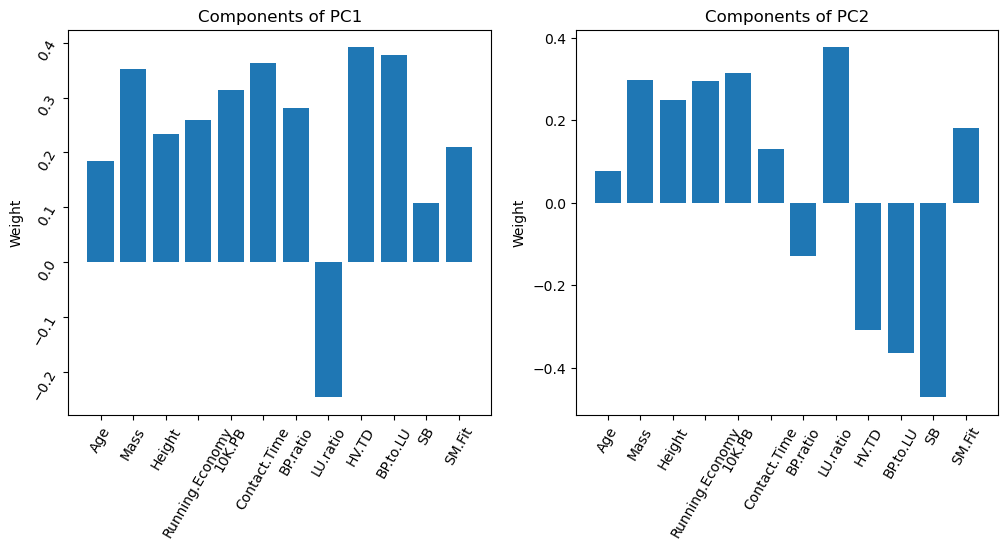

In [46]:
# Try to see if any of the variables have a lot of weight on PC1 and PC2
# It seems like most of the variables hold a decent amount of weight. HV.TD (Horizontal and vertical force transition timing difference)
# Seems to hold the most weight for PC1, but this does not imply it is the most important predictor
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].bar(data_num.columns, pca.components_[0])
ax[0].set_title("Components of PC1")
ax[0].set_ylabel("Weight")
ax[0].tick_params(labelrotation=60)

ax[1].bar(data_num.columns, pca.components_[1])
ax[1].set_title("Components of PC2")
ax[1].set_ylabel("Weight")
plt.xticks(rotation=60, fontsize=10)
plt.show()

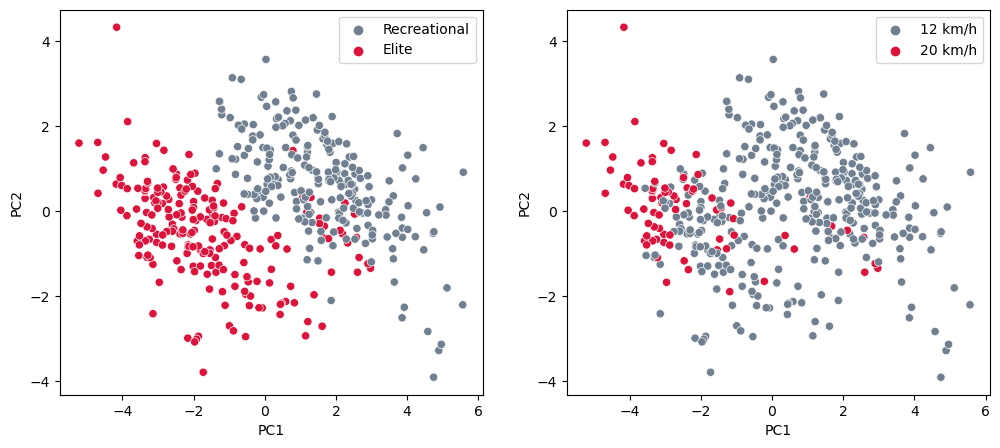

In [48]:
# See if there are clearly distinct patterns for the groups and speed of runners
# The metrics clearly distinguish between the eliet and recreational, but there is no obvious pattern for speed
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

pca_df = pd.DataFrame(data_num_pca[:,:2], columns  = ['PC1','PC2'])
pca_df['target'] = data_notNA['Group']
ax[0] = sns.scatterplot(data = pca_df, x = 'PC1', y = 'PC2', hue = 'target', palette = ['slategrey','crimson'], ax=ax[0])
ax[0].legend(ax[0].get_legend_handles_labels()[0], ['Recreational', 'Elite'])

pca_df['target'] = data_notNA['Speed']
ax[1] = sns.scatterplot(data = pca_df, x = 'PC1', y = 'PC2', hue = 'target', palette = ['slategrey','crimson'], ax=ax[1])
plt.legend(ax[1].get_legend_handles_labels()[0], ['12 km/h', '20 km/h'])
plt.show()

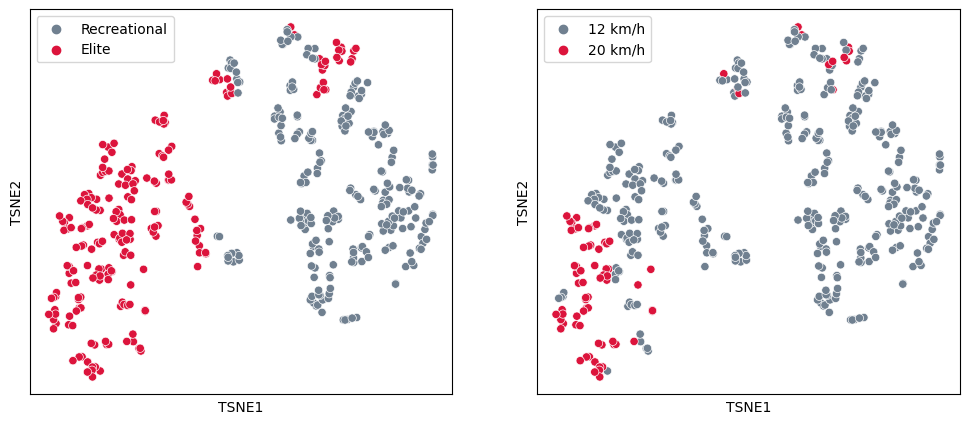

In [60]:
# Do the same thing with TSNE. The same results emerge
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

tsne = TSNE(random_state = 30)
tsne_X = tsne.fit_transform(data_num_scaled)
tsne_df = pd.DataFrame(tsne_X[:,:2], columns  = ['TSNE1','TSNE2'])

tsne_df['target'] = data_notNA['Group']
ax[0] = sns.scatterplot(data = tsne_df, x = 'TSNE1', y = 'TSNE2', hue = 'target', palette = ['slategrey','crimson'], ax=ax[0])
ax[0].legend(ax[0].get_legend_handles_labels()[0], ['Recreational', 'Elite'])

tsne_df['target'] = data_notNA['Speed']
ax[1] = sns.scatterplot(data = tsne_df, x = 'TSNE1', y = 'TSNE2', hue = 'target', palette = ['slategrey','crimson'], ax=ax[1])
ax[1].legend(ax[1].get_legend_handles_labels()[0], ['12 km/h', '20 km/h'])

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

<font color='green'>Start of regression</font>

In [61]:
# Look at the correlations between the quantitative variables. We are most interested in 10K.PB since we will
# be building a model to predict that. It seems correlated most with Running.Economy (form of VO2 max) and Contact.Time
data_num.corr()

,Age,Mass,Height,Running.Economy,10K.PB,Contact.Time,BP.ratio,LU.ratio,HV.TD,BP.to.LU,SB,SM.Fit
Age,1.000000,0.344433,0.124094,0.163159,0.374422,0.316086,0.324793,-0.157768,0.328351,0.309037,0.031950,0.071350
Mass,0.344433,1.000000,0.722342,0.486272,0.605589,0.623189,0.272308,-0.359006,0.513413,0.459231,0.032813,0.522155
Height,0.124094,0.722342,1.000000,0.208171,0.204435,0.407668,0.060743,-0.247775,0.271663,0.237189,-0.016945,0.278240
Running.Economy,0.163159,0.486272,0.208171,1.000000,0.650683,0.537760,0.218296,-0.195077,0.339258,0.315600,0.018441,0.270909
10K.PB,0.374422,0.605589,0.204435,0.650683,1.000000,0.662787,0.475350,-0.081382,0.431154,0.378678,-0.004230,0.296498
Contact.Time,0.316086,0.623189,0.407668,0.537760,0.662787,1.000000,0.495910,-0.335605,0.633577,0.581709,0.108995,0.259251
BP.ratio,0.324793,0.272308,0.060743,0.218296,0.475350,0.495910,1.000000,0.007791,0.654669,0.651217,0.239986,0.208352
LU.ratio,-0.157768,-0.359006,-0.247775,-0.195077,-0.081382,-0.335605,0.007791,1.000000,-0.701926,-0.729554,-0.285293,-0.212205
HV.TD,0.328351,0.513413,0.271663,0.339258,0.431154,0.633577,0.654669,-0.701926,1.000000,0.985285,0.310344,0.342280
BP.to.LU,0.309037,0.459231,0.237189,0.315600,0.378678,0.581709,0.651217,-0.729554,0.985285,1.000000,0.357624,0.313502


In [67]:
# Set up the data to start looking at regression models
X = data_num_notNA.drop(columns = ['10K.PB']).values
X_names = data_num_notNA.drop(columns = ['10K.PB']).columns
y = data_num_notNA["10K.PB"].values

# Split up training and validation sets
Xtrain, Xtest, ytrain, ytest = tts(X,y,random_state = 2, shuffle = True, test_size = 0.25)

# Scale the data for lasso regression and to make it easier to evaluate coefficients
ss = SS()
XtrainS = ss.fit_transform(Xtrain)
XtestS = ss.transform(Xtest)

In [64]:
# Look at ordinary regression first - it seems pretty accurate, and the predicted 10k time (which was missing in the data)
# seems reasonable for an elite runner
lin_reg = LR()
lin_reg.fit(Xtrain, ytrain)
print("Training score: ", lin_reg.score(Xtrain, ytrain), "\nTesting score: ", lin_reg.score(Xtest, ytest))
print("Predicted 10k time for one elite runner: ", lin_reg.predict(data_num.drop(columns=['10K.PB']).iloc[181].values.reshape(1, -1))[0])

Training score:  0.74952729202184 
Testing score:  0.6645073986643011
Predicted 10k time for one elite runner:  28.773180186933793


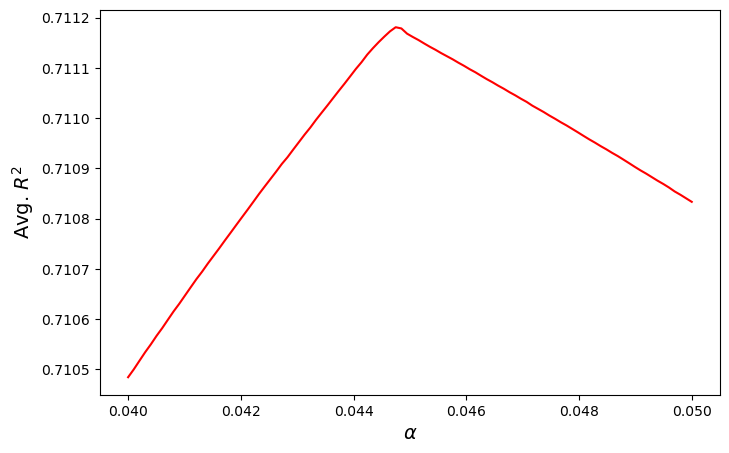

Optimal alpha in the range tested:  0.04474747474747475
Avg. training score at this value:  0.7276226218453551
Avg. testing score at this value:  0.7111807492482346


In [66]:
# Find the optimal hyperparameter for lasso regression by finding the highest average test score for different alphas
a_range = np.linspace(.04, .05, 100)
k = 10

avg_tr_score=[]
avg_te_score=[]

for a in a_range:
    las_reg = Lasso(alpha=a)
    train_scores, test_scores = do_Kfold(las_reg, X, y, k, SS(), random_state = 201)
    
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))
    
plt.figure(figsize=(8,5))
plt.plot(a_range, avg_te_score, color='r', label='Testing')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('Avg. $R^2$', fontsize=14)
plt.show()
idx_max = np.argmax(avg_te_score)

print('Optimal alpha in the range tested: ', a_range[idx_max]) # alpha = 0.04474747474747475
print('Avg. training score at this value: ', avg_tr_score[idx_max])
print('Avg. testing score at this value: ', avg_te_score[idx_max])

In [70]:
# Now look more closely at the lasso regressor with the optimal alpha value
las_reg = Lasso(alpha=0.04474747474747475)
las_reg.fit(XtrainS, ytrain)
# Look at scores and predict the 10k time for an elite runner
print("Training score: ", las_reg.score(XtrainS, ytrain), "\nTesting score: ", las_reg.score(XtestS, ytest),
      "\nPredicted 10k: ", las_reg.predict(ss.transform(data_num.drop(columns='10K.PB').iloc[131].values.reshape(1, -1)))[0])

# Now fit to all of the data
las_reg = Lasso(alpha=0.04474747474747475)
ss = SS()
Xscaled = ss.fit_transform(X)
las_reg.fit(Xscaled, y)
print("\nScore: ", las_reg.score(Xscaled, y), "\nPredicted 10k: ", 
      las_reg.predict(ss.transform(data_num.drop(columns='10K.PB').iloc[131].values.reshape(1, -1)))[0])

# Look at the coefficients. The magnitudes demonstrate the relative importance, so the top three predictors are
# Mass, Height, and Running.Economy. HV.TD is actually removed as a feature
pd.Series(las_reg.coef_, index = data_num_notNA.drop(columns = '10K.PB').columns)

Training score:  0.7473016081715073 
Testing score:  0.666361436964302 
Predicted 10k:  31.614147728033313

Score:  0.7271983360097808 
Predicted 10k:  31.804216051424376


Age                0.947375
Mass               4.375757
Height            -2.980603
Running.Economy    2.657187
Contact.Time       2.221909
BP.ratio           1.794617
LU.ratio           0.136993
HV.TD              0.000000
BP.to.LU          -1.267399
SB                -0.362496
SM.Fit            -0.016957
dtype: float64

In [72]:
# Just looking at a random forest regressor. The accuracy is very high but the model is way overfit and probably useless
RF_reg = RFR(random_state=100)
RF_reg.fit(XtrainS, ytrain)
print("Training score: ", RF_reg.score(XtrainS, ytrain), "\nTesting score: ", RF_reg.score(XtestS, ytest))
print("Predicted 10K: ", RF_reg.predict(ss.transform(data_num.drop(columns='10K.PB').iloc[131].values.reshape(1, -1)))[0])

Training score:  0.9988626117367835 
Testing score:  0.9940367764386033
Predicted 10K:  28.45999999999997


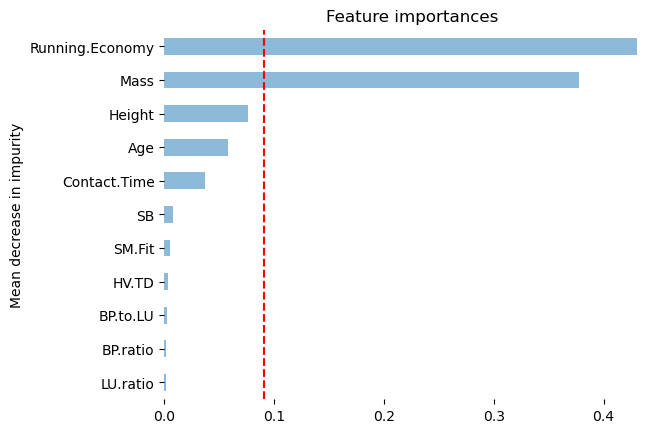

In [73]:
# Look at the importance of each feature for the random forest regressor. The top three are the same as for lasso
# regression, but Running.economy seems to be very important for the fitness of the runners in this data
forest_importances = pd.Series(RF_reg.feature_importances_,  X_names)
fig, ax = plt.subplots()
forest_importances.sort_values().plot.barh(ax=ax, alpha = 0.5)
plt.axvline(forest_importances.mean(), c = 'r',linestyle = '--' )
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.show()

<font color='green'>Start of classification</font>

In [76]:
# Set up the data to start looking at classification models. We first model the speed of runs.
X = data_num_notNA.drop(columns = ['10K.PB']).values
X_names = data_num_notNA.drop(columns = ['10K.PB']).columns
y = data_notNA["Speed"].values

# Split the data into training and testing
Xtrain, Xtest, ytrain, ytest = tts(X,y,random_state = 201, shuffle = True, test_size = 0.25)

# Scale the data since KNN and logistic regression rely on distance measurements
ss = SS()
XtrainS = ss.fit_transform(Xtrain)
XtestS = ss.transform(Xtest)

In [78]:
# We will compare a few different classification models
# First optimize the KNN hyperparameter
neighbor_range = np.array(range(2,20))

train=[]
test=[]

k = 10

# For each value of the hyperparameter, fit to a selection of training data and find the average test score
for n_neighbors in neighbor_range:
    knn = KNN(n_neighbors=n_neighbors, weights="distance")
    tr,te = do_Kfold(knn,X,y,k, SS())
    train.append(np.mean(tr))
    test.append(np.mean(te))
    
idx = test == np.max(test)
print("Best hyperparameter(s): ", neighbor_range[idx])
print("Best test score: ", np.max(test))
print("Best training score: ", np.max(train))

Best hyperparameter(s):  [2 4]
Best test score:  0.9893154486586493
Best training score:  1.0


In [86]:
# Now fit KNN to the originally split training data
knn = KNN(n_neighbors = 4, weights="distance")
knn.fit(XtrainS, ytrain)
print("Training score: ", knn.score(XtrainS, ytrain))
compare_classes(ytest, knn.predict(XtestS))

Training score:  1.0
Accuracy = 0.99


(Predicted    0   1
 Actual            
 0          100   0
 1            1  16,
 0.9914529914529915)

In [88]:
# Now look at logistic regression and compare to the KNN model
# Both models perform very well
log_reg = LogR()
log_reg.fit(XtrainS, ytrain)
print("Training score: ", log_reg.score(XtrainS, ytrain))
compare_classes(ytest, log_reg.predict(XtestS))

Training score:  1.0
Accuracy = 1.00


(Predicted    0   1
 Actual            
 0          100   0
 1            0  17,
 1.0)

In [164]:
# We can do the same with a random forest, but again these are very overfit so we probably will not use it
param_grid = dict(n_estimators=[100,500], max_leaf_nodes = [5,10,15],
                 min_samples_split = [2,3,4,5])
cv = KFold(n_splits=10, random_state = 201, shuffle = True)
grid = GridSearchCV(RFC(random_state = 201), param_grid=param_grid, cv=cv, 
                    scoring='accuracy')
grid.fit(Xtrain, ytrain)
pd.DataFrame(grid.cv_results_)[['param_n_estimators','param_max_leaf_nodes',
                                'param_min_samples_split','mean_test_score','rank_test_score']]

,param_n_estimators,param_max_leaf_nodes,param_min_samples_split,mean_test_score,rank_test_score
0,100,5,2,0.985714,17
1,500,5,2,0.982857,21
2,100,5,3,0.985714,17
3,500,5,3,0.982857,21
4,100,5,4,0.985714,17
5,500,5,4,0.982857,21
6,100,5,5,0.985714,17
7,500,5,5,0.982857,21
8,100,10,2,0.988571,7
9,500,10,2,0.988571,7


In [93]:
# Fit the RFC using the measured optimal hyperparameters
rfc = RFC(n_estimators = 100, max_leaf_nodes = 10,min_samples_split = 3, random_state = 201)
rfc.fit(XtrainS, ytrain)
print("Training score: ", rfc.score(XtrainS, ytrain))
compare_classes(ytest, rfc.predict(XtestS))

Training score:  1.0
Accuracy = 0.96


(Predicted   0   1
 Actual           
 0          98   2
 1           3  14,
 0.9572649572649573)

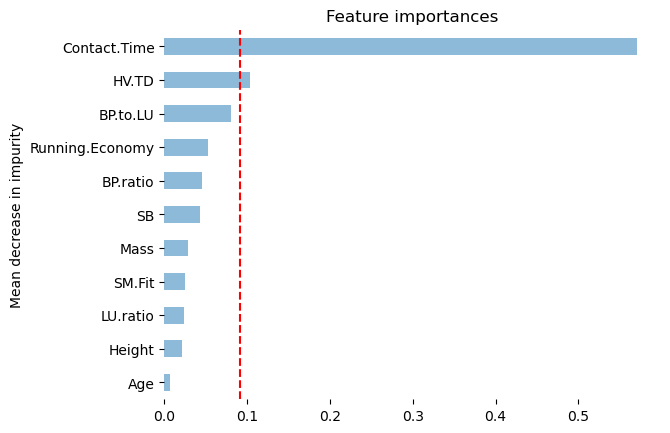

In [94]:
# Look at how important the features are for the classifier. Results are very different from the regression and
# now the Contact.Time seems very important (this measure is biased toward predictors with many unqiue values)
forest_importances = pd.Series(rfc.feature_importances_,  X_names)
fig, ax = plt.subplots()
forest_importances.sort_values().plot.barh(ax=ax, alpha = 0.5)
plt.axvline(forest_importances.mean(), c = 'r',linestyle = '--' )
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.show()

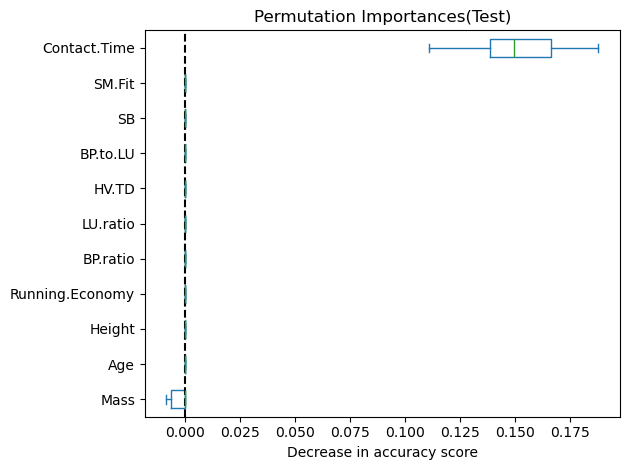

In [96]:
from sklearn.inspection import permutation_importance

# Do the same thing with permutations. Contact.Time seems to be the most important factor in speed
result = permutation_importance(
    rfc, XtestS, ytest, n_repeats=10, random_state=201, n_jobs=2
)
X_df = pd.DataFrame(Xtest, columns = X_names)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_df.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances(Test)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [97]:
# Now try to predict if a runner is elite
X = data_num_notNA.drop(columns = ['10K.PB']).values
X_names = data_num_notNA.drop(columns = ['10K.PB']).columns
y = data_notNA["Group"].values

# Split the data into training and testing
Xtrain, Xtest, ytrain, ytest = tts(X,y,random_state = 201, shuffle = True, test_size = 0.25)

# Scale the data since KNN and logistic regression rely on distance measurements
ss = SS()
XtrainS = ss.fit_transform(Xtrain)
XtestS = ss.transform(Xtest)

In [98]:
# First optimize the KNN hyperparameter
neighbor_range = np.array(range(2,20))

train=[]
test=[]

k = 10

# For each value of the hyperparameter, fit to a selection of training data and find the average test score
for n_neighbors in neighbor_range:
    knn = KNN(n_neighbors=n_neighbors, weights="distance")
    tr,te = do_Kfold(knn,X,y,k, SS())
    train.append(np.mean(tr))
    test.append(np.mean(te))
    
idx = test == np.max(test)
print("Best hyperparameter(s): ", neighbor_range[idx])
print("Best test score: ", np.max(test))
print("Best training score: ", np.max(train))

Best hyperparameter(s):  [5 6]
Best test score:  0.9978260869565216
Best training score:  1.0


In [101]:
# Now fit KNN to the originally split training data
knn = KNN(n_neighbors = 5, weights="distance")
knn.fit(XtrainS, ytrain)
print("Training score: ", knn.score(XtrainS, ytrain))
compare_classes(ytest, knn.predict(XtestS))

Training score:  1.0
Accuracy = 1.00


(Predicted   0   1
 Actual           
 0          64   0
 1           0  53,
 1.0)

In [103]:
# Now look at logistic regression and compare to the KNN model
# Both models perform very well again
log_reg = LogR()
log_reg.fit(XtrainS, ytrain)
print("Training score: ", log_reg.score(XtrainS, ytrain))
compare_classes(ytest, log_reg.predict(XtestS))

Training score:  0.98005698005698
Accuracy = 0.97


(Predicted   0   1
 Actual           
 0          61   3
 1           1  52,
 0.9658119658119658)

In [104]:
# We can again look at a random forest but we likely will not end up using it
rfc = RFC(n_estimators = 100, max_leaf_nodes = 10,min_samples_split = 3, random_state = 201)
rfc.fit(X, y)
print(rfc.score(Xtrain, ytrain))
compare_classes(ytest, rfc.predict(Xtest))

1.0
Accuracy = 1.00


(Predicted   0   1
 Actual           
 0          64   0
 1           0  53,
 1.0)

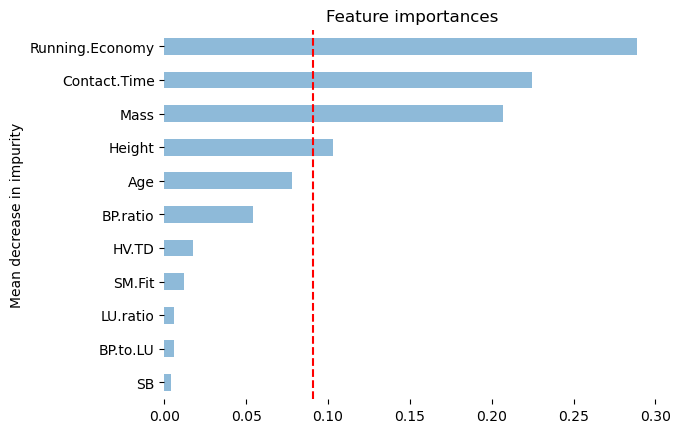

In [107]:
# Evaluate feature importances. This time, the results are similar to the regression models, but Contact.Time is
# still important. This is useful because there is a lot of debate as to whether contact time truly matters, and
# it seems that this metric can actually make a difference between elite and recreational runners
forest_importances = pd.Series(rfc.feature_importances_,  X_names)
fig, ax = plt.subplots()
forest_importances.sort_values().plot.barh(ax=ax, alpha = 0.5)
plt.axvline(forest_importances.mean(), c = 'r',linestyle = '--' )
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.show()

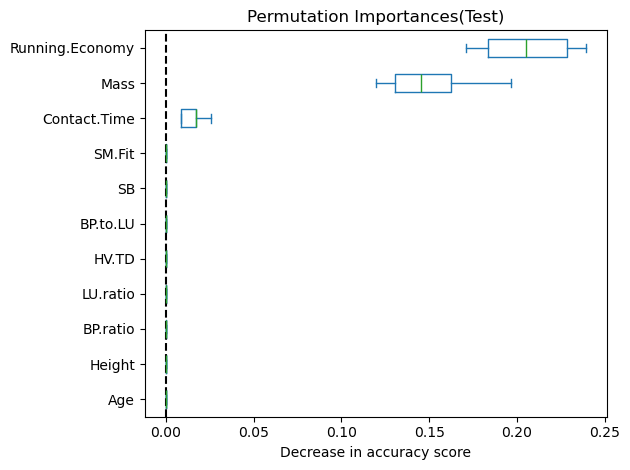

In [108]:
from sklearn.inspection import permutation_importance

# Do the same with permutations, and the top predictors are similar
result = permutation_importance(
    rfc, Xtest, ytest, n_repeats=10, random_state=201, n_jobs=2
)
X_df = pd.DataFrame(Xtest, columns = X_names)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_df.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances(Test)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

<font color='green'>Final models</font>

In [111]:
# Now we understand what metrics are useful for evaluating running performance, but we need to
# narrow down the ones to which the average runner will have access 
X = data_num_notNA[["Running.Economy", "Mass", "Age", "Height"]].values
X_names = data_num_notNA[["Running.Economy", "Mass", "Age", "Height"]].columns
y = data_num_notNA["10K.PB"].values

# Scale the data for lasso regression
ss = SS()
Xscaled = ss.fit_transform(X)
las_reg = Lasso(alpha=0.04474747474747475)
las_reg.fit(Xscaled, y)
print("Score: ", las_reg.score(Xscaled, y),
      "\nPredicted 10k: ", las_reg.predict(ss.transform(data_num[["Running.Economy", "Mass", "Age", "Height"]].iloc[131].values.reshape(1, -1)))[0])
pd.Series(las_reg.coef_, index = data_num_notNA[["Running.Economy", "Mass", "Age", "Height"]].columns)

Score:  0.6445377229562419 
Predicted 10k:  28.34619950611685


Running.Economy    3.383486
Mass               5.235270
Age                1.494616
Height            -3.153305
dtype: float64

In [119]:
X = data_num_notNA[["Running.Economy", "Mass", "Age", "Height"]].values
y = data_notNA["Group"].values

ss = SS()
Xscaled = ss.fit_transform(X)

# Fit the logistic regressor and predict if a runner is elite
log_R = KNN(n_neighbors=5, weights="distance")
log_R.fit(Xscaled, y)
print("Score: ", log_R.score(Xscaled, y),
      "\nIs Elite: ", 1 == log_R.predict(ss.transform(data_num[["Running.Economy", "Mass", "Age", "Height"]].iloc[131].values.reshape(1, -1)))[0])
compare_classes(y, log_R.predict(Xscaled))

Score:  1.0 
Is Elite:  True
Accuracy = 1.00


(Predicted    0    1
 Actual             
 0          260    0
 1            0  208,
 1.0)